In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Load the merged master dataset
merged_data_path = os.path.join(os.getcwd(), 'data', 'merged_data')
master_train_path = os.path.join(merged_data_path, 'master_train.csv')

df = pd.read_csv(master_train_path, low_memory=False)
df['date'] = pd.to_datetime(df['date'])
df = df.convert_dtypes()

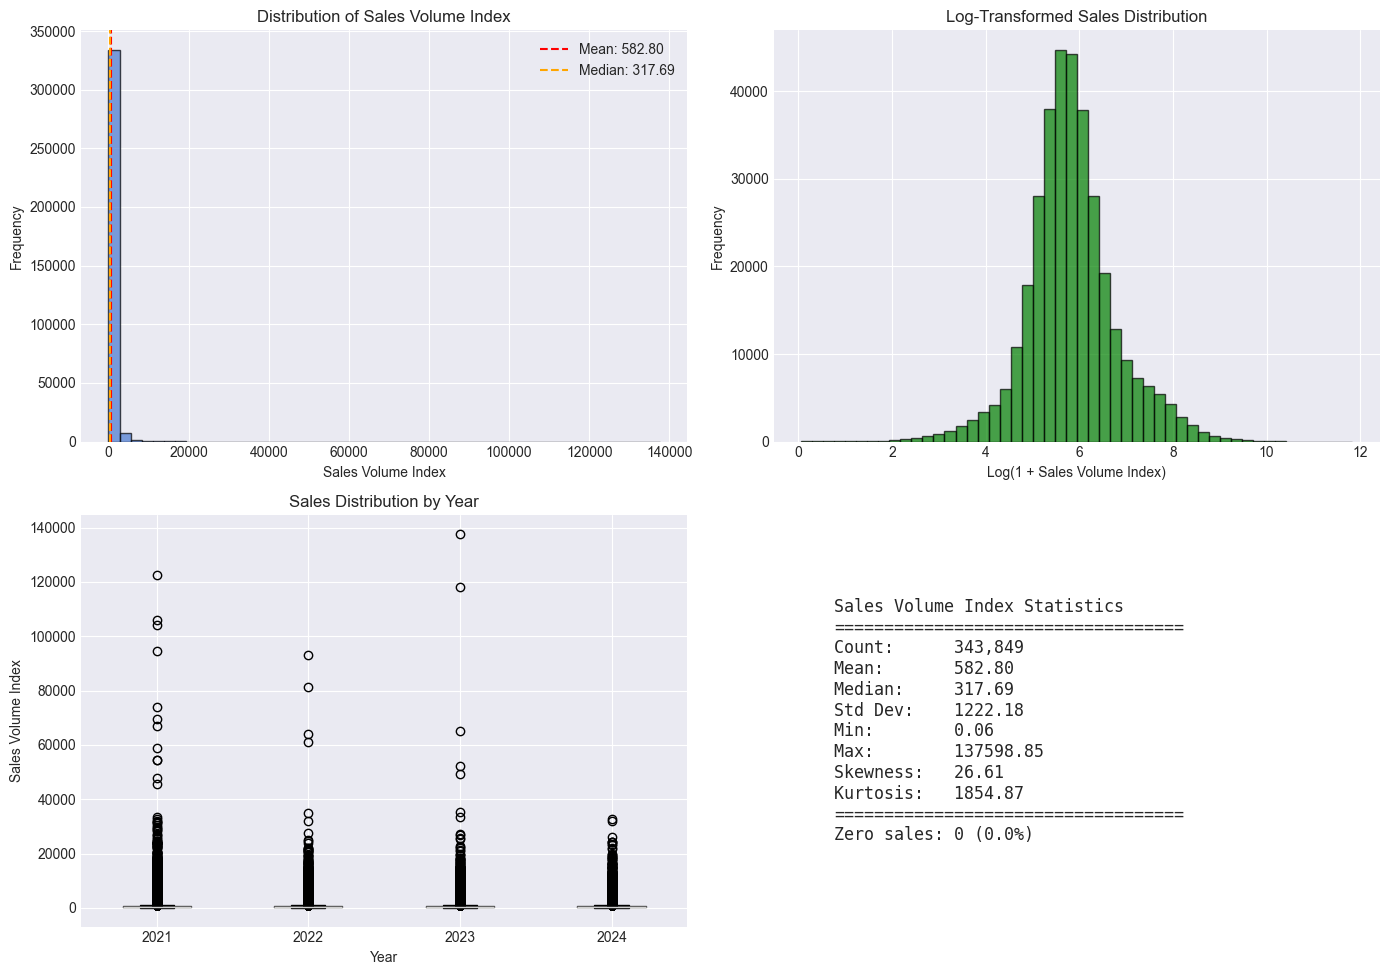

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of sales volume index
ax1 = axes[0, 0]
df['sales_volume_index'].hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.axvline(df['sales_volume_index'].mean(), color='red', linestyle='--', label=f"Mean: {df['sales_volume_index'].mean():.2f}")
ax1.axvline(df['sales_volume_index'].median(), color='orange', linestyle='--', label=f"Median: {df['sales_volume_index'].median():.2f}")
ax1.set_xlabel('Sales Volume Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales Volume Index')
ax1.legend()

# 2. Log-transformed distribution (common for sales data)
ax2 = axes[0, 1]
df_positive = df[df['sales_volume_index'] > 0]['sales_volume_index']
np.log1p(df_positive).hist(bins=50, ax=ax2, edgecolor='black', alpha=0.7, color='green')
ax2.set_xlabel('Log(1 + Sales Volume Index)')
ax2.set_ylabel('Frequency')
ax2.set_title('Log-Transformed Sales Distribution')

# 3. Box plot by year
ax3 = axes[1, 0]
df['year'] = df['date'].dt.year
df.boxplot(column='sales_volume_index', by='year', ax=ax3)
ax3.set_xlabel('Year')
ax3.set_ylabel('Sales Volume Index')
ax3.set_title('Sales Distribution by Year')
plt.suptitle('')

# 4. Key statistics
ax4 = axes[1, 1]
ax4.axis('off')
stats_text = f"""
Sales Volume Index Statistics
{'='*35}
Count:      {df['sales_volume_index'].count():,.0f}
Mean:       {df['sales_volume_index'].mean():.2f}
Median:     {df['sales_volume_index'].median():.2f}
Std Dev:    {df['sales_volume_index'].std():.2f}
Min:        {df['sales_volume_index'].min():.2f}
Max:        {df['sales_volume_index'].max():.2f}
Skewness:   {df['sales_volume_index'].skew():.2f}
Kurtosis:   {df['sales_volume_index'].kurtosis():.2f}
{'='*35}
Zero sales: {(df['sales_volume_index'] == 0).sum():,} ({(df['sales_volume_index'] == 0).mean()*100:.1f}%)
"""
ax4.text(0.1, 0.5, stats_text, fontsize=12, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.show()

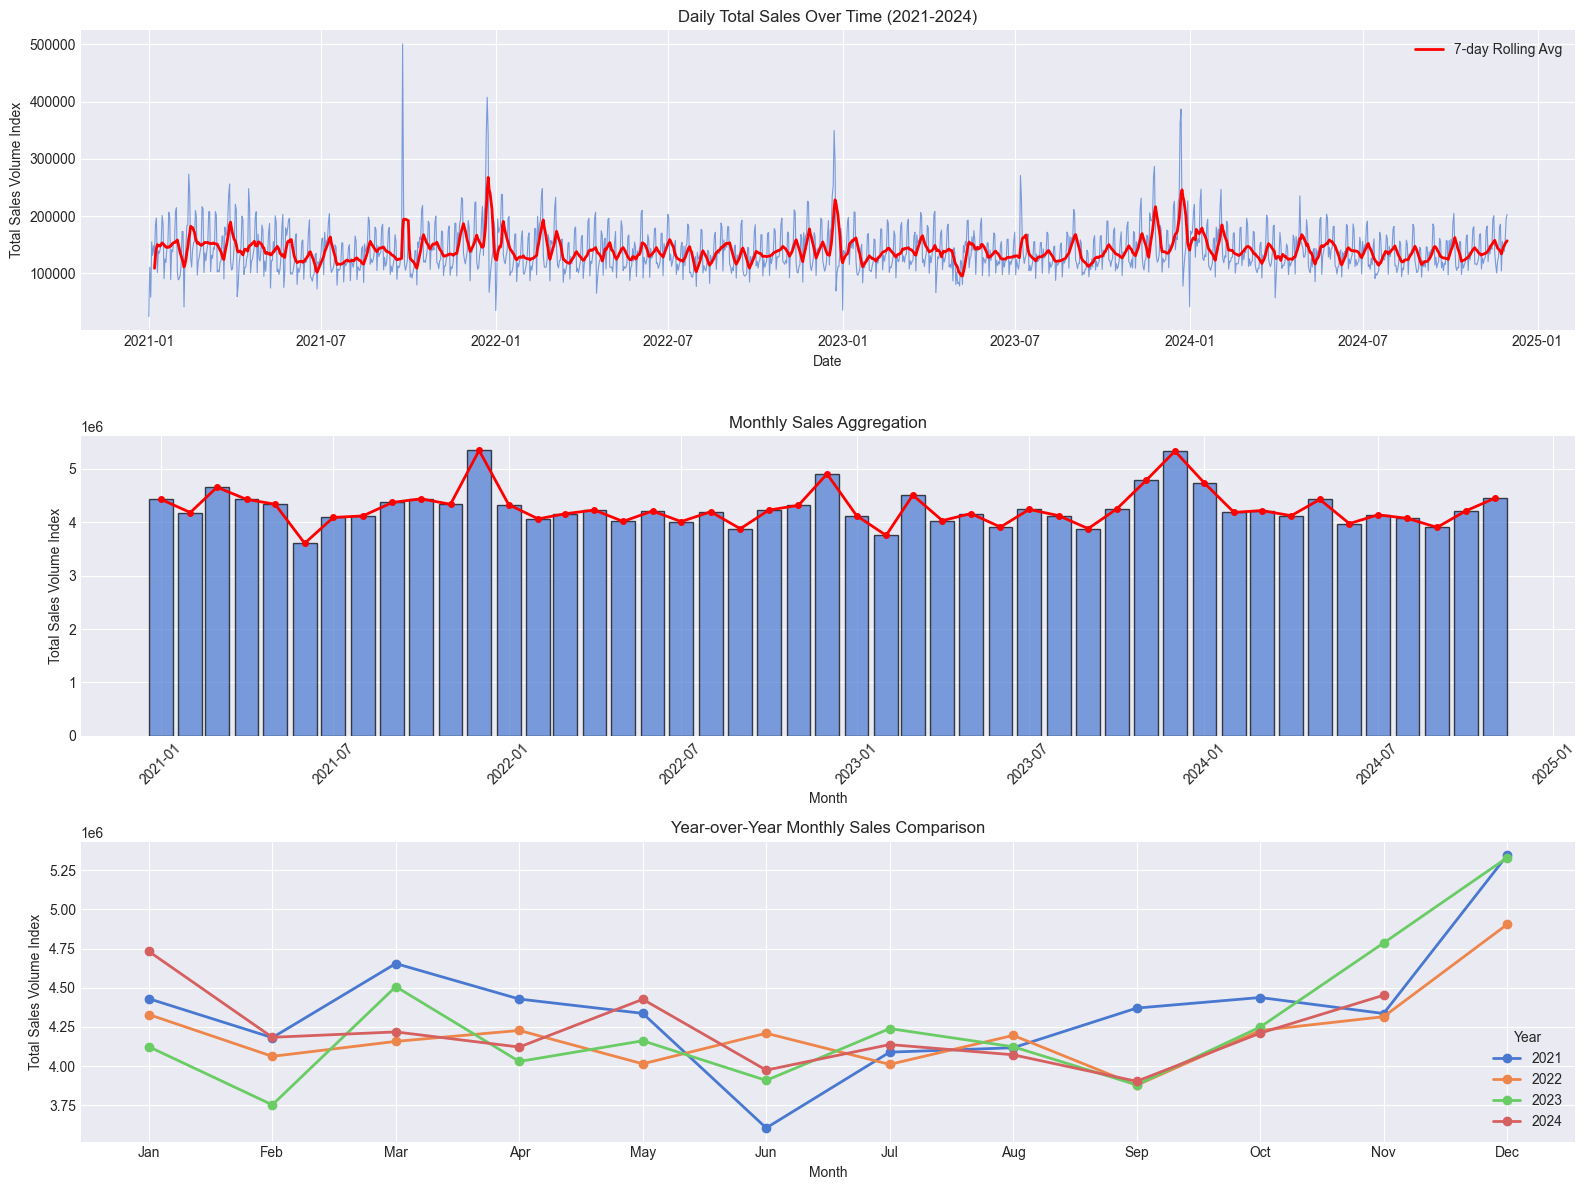

In [4]:
# Aggregate sales by date
daily_sales = df.groupby('date').agg({
    'sales_volume_index': 'sum',
    'articleId': 'count'
}).rename(columns={'articleId': 'num_transactions'})

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Daily total sales over time
ax1 = axes[0]
ax1.plot(daily_sales.index, daily_sales['sales_volume_index'], linewidth=0.8, alpha=0.7)
# Add 7-day rolling average
rolling_avg = daily_sales['sales_volume_index'].rolling(window=7).mean()
ax1.plot(daily_sales.index, rolling_avg, color='red', linewidth=2, label='7-day Rolling Avg')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Volume Index')
ax1.set_title('Daily Total Sales Over Time (2021-2024)')
ax1.legend()

# 2. Monthly aggregated sales with trend
ax2 = axes[1]
monthly_sales = df.groupby(df['date'].dt.to_period('M'))['sales_volume_index'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()
ax2.bar(monthly_sales.index, monthly_sales.values, width=25, alpha=0.7, edgecolor='black')
ax2.plot(monthly_sales.index, monthly_sales.values, color='red', linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Sales Volume Index')
ax2.set_title('Monthly Sales Aggregation')
ax2.tick_params(axis='x', rotation=45)

# 3. Year-over-year comparison
ax3 = axes[2]
df['month'] = df['date'].dt.month
monthly_by_year = df.groupby(['year', 'month'])['sales_volume_index'].sum().unstack(level=0)
monthly_by_year.plot(ax=ax3, marker='o', linewidth=2)
ax3.set_xlabel('Month')
ax3.set_ylabel('Total Sales Volume Index')
ax3.set_title('Year-over-Year Monthly Sales Comparison')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.legend(title='Year')

plt.tight_layout()
plt.show()

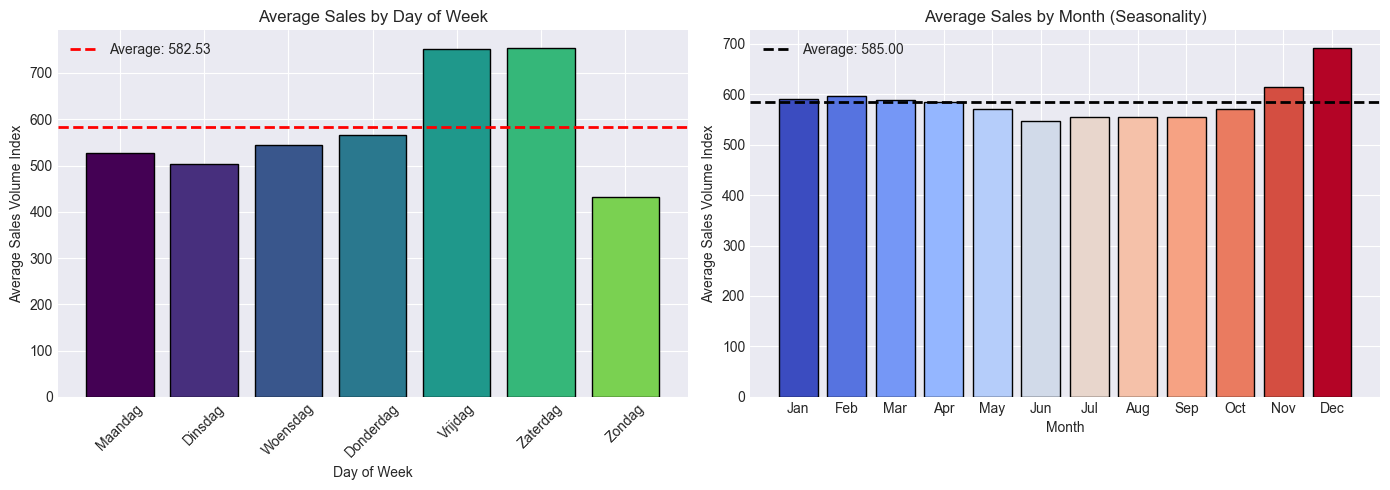

In [5]:
# Seasonality Analysis - Day of Week and Month patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Day of Week pattern
ax1 = axes[0]
dow_order =  ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']
dow_sales = df.groupby('doWName')['sales_volume_index'].mean().reindex(dow_order)
colors = plt.cm.viridis(np.linspace(0, 0.8, len(dow_order)))
bars = ax1.bar(dow_order, dow_sales.values, color=colors, edgecolor='black')
ax1.axhline(dow_sales.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {dow_sales.mean():.2f}')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Average Sales Volume Index')
ax1.set_title('Average Sales by Day of Week')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Month pattern
ax2 = axes[1]
month_sales = df.groupby('month')['sales_volume_index'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = plt.cm.coolwarm(np.linspace(0, 1, 12))
bars = ax2.bar(month_names, month_sales.values, color=colors, edgecolor='black')
ax2.axhline(month_sales.mean(), color='black', linestyle='--', linewidth=2, label=f'Average: {month_sales.mean():.2f}')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Sales Volume Index')
ax2.set_title('Average Sales by Month (Seasonality)')
ax2.legend()

plt.tight_layout()
plt.show()

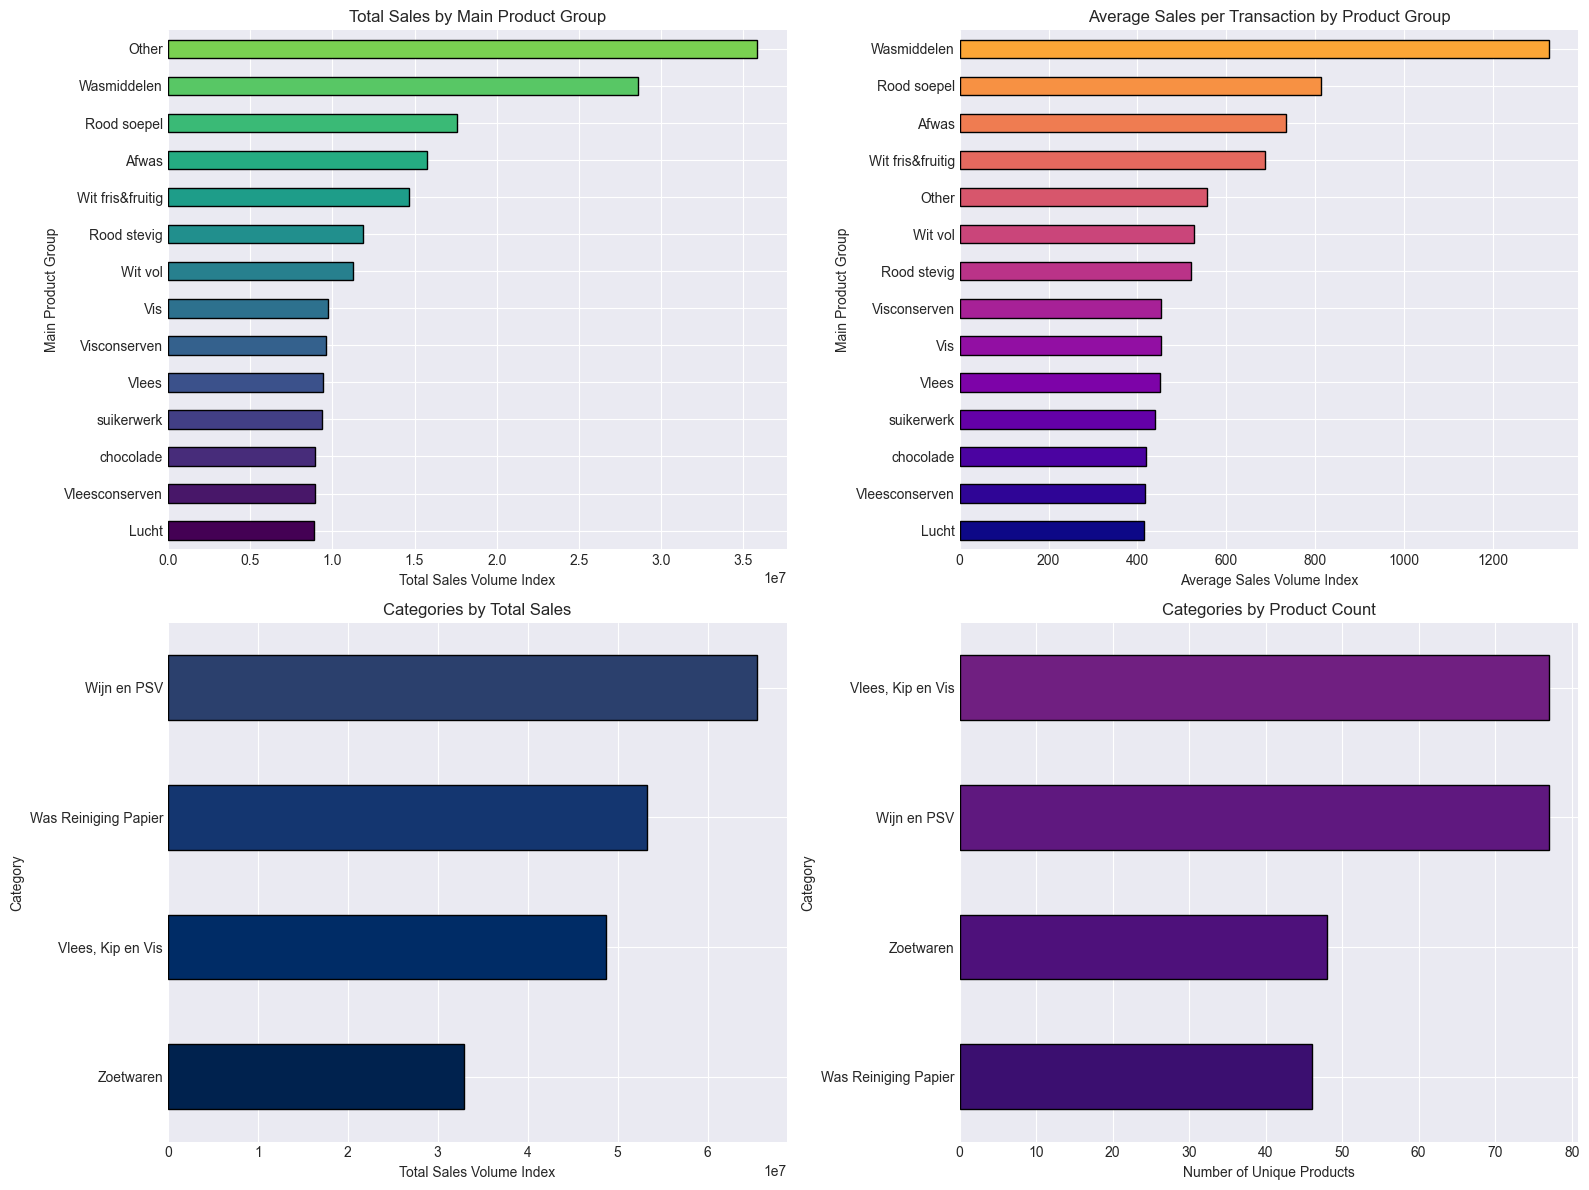

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sales by Main Product Group
ax1 = axes[0, 0]
group_sales = df.groupby('mainProductGroup')['sales_volume_index'].sum().sort_values(ascending=True)
group_sales.plot(kind='barh', ax=ax1, color=plt.cm.viridis(np.linspace(0, 0.8, len(group_sales))), edgecolor='black')
ax1.set_xlabel('Total Sales Volume Index')
ax1.set_ylabel('Main Product Group')
ax1.set_title('Total Sales by Main Product Group')

# 2. Average sales per transaction by Product Group
ax2 = axes[0, 1]
group_avg = df.groupby('mainProductGroup')['sales_volume_index'].mean().sort_values(ascending=True)
group_avg.plot(kind='barh', ax=ax2, color=plt.cm.plasma(np.linspace(0, 0.8, len(group_avg))), edgecolor='black')
ax2.set_xlabel('Average Sales Volume Index')
ax2.set_ylabel('Main Product Group')
ax2.set_title('Average Sales per Transaction by Product Group')

# 3. Categories by total sales
ax3 = axes[1, 0]
cat_sales = df.groupby('category')['sales_volume_index'].sum().sort_values(ascending=False).head(15)
cat_sales[::-1].plot(kind='barh', ax=ax3, color=plt.cm.cividis(np.linspace(0, 0.8, 15)), edgecolor='black')
ax3.set_xlabel('Total Sales Volume Index')
ax3.set_ylabel('Category')
ax3.set_title('Categories by Total Sales')

# 4. Number of products per category
ax4 = axes[1, 1]
cat_products = df.groupby('category')['articleId'].nunique().sort_values(ascending=False).head(15)
cat_products[::-1].plot(kind='barh', ax=ax4, color=plt.cm.magma(np.linspace(0.2, 0.8, 15)), edgecolor='black')
ax4.set_xlabel('Number of Unique Products')
ax4.set_ylabel('Category')
ax4.set_title('Categories by Product Count')

plt.tight_layout()
plt.show()

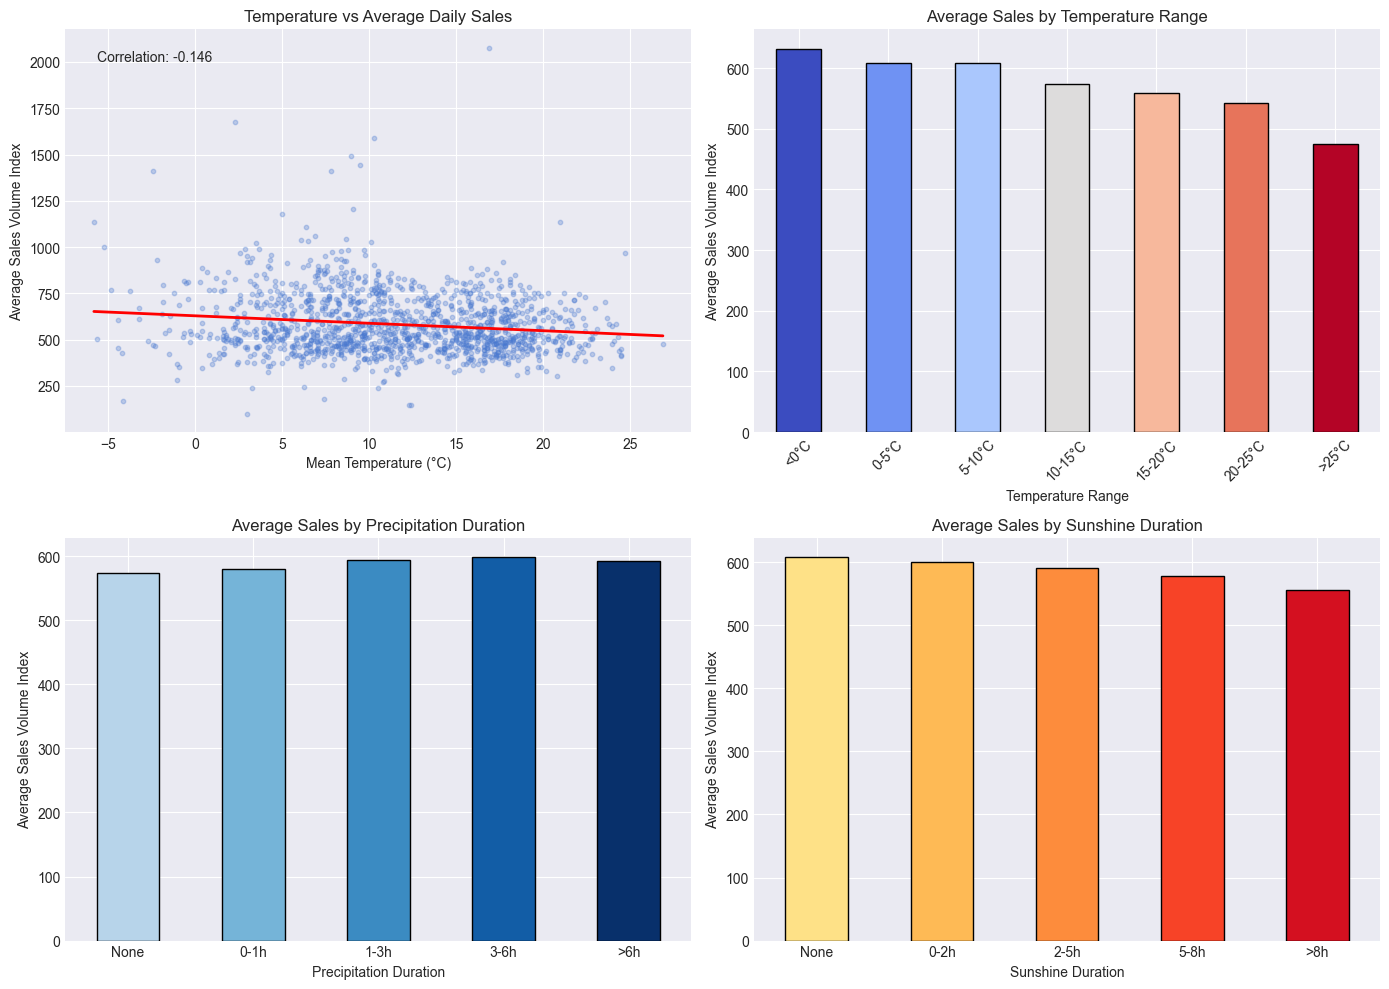

In [7]:
# Select key weather features for analysis
# Note: temperature values are in 0.1 degrees Celsius, so we divide by 10
df['mean_temp_c'] = df['mean_temp'] / 10
df['max_temp_c'] = df['max_temp'] / 10
df['min_temp_c'] = df['min_temp'] / 10

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Temperature vs Sales (scatter with trend)
ax1 = axes[0, 0]
# Aggregate by date first for clearer visualization
daily_data = df.groupby('date').agg({
    'sales_volume_index': 'mean',
    'mean_temp_c': 'first',
    'rel_humidity': 'first',
    'sunshine_hours': 'first',
    'precip_duration': 'first'
})
ax1.scatter(daily_data['mean_temp_c'], daily_data['sales_volume_index'], alpha=0.3, s=10)
z = np.polyfit(daily_data['mean_temp_c'], daily_data['sales_volume_index'], 1)
p = np.poly1d(z)
x_line = np.linspace(daily_data['mean_temp_c'].min(), daily_data['mean_temp_c'].max(), 100)
ax1.plot(x_line, p(x_line), color='red', linewidth=2, label=f'Trend line')
ax1.set_xlabel('Mean Temperature (°C)')
ax1.set_ylabel('Average Sales Volume Index')
ax1.set_title('Temperature vs Average Daily Sales')
corr = daily_data['mean_temp_c'].corr(daily_data['sales_volume_index'])
ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes, fontsize=10, verticalalignment='top')

# 2. Sales by temperature bins
ax2 = axes[0, 1]
df['temp_bin'] = pd.cut(df['mean_temp_c'], bins=[-10, 0, 5, 10, 15, 20, 25, 35], labels=['<0°C', '0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '>25°C'])
temp_sales = df.groupby('temp_bin', observed=True)['sales_volume_index'].mean()
colors = plt.cm.coolwarm(np.linspace(0, 1, len(temp_sales)))
temp_sales.plot(kind='bar', ax=ax2, color=colors, edgecolor='black')
ax2.set_xlabel('Temperature Range')
ax2.set_ylabel('Average Sales Volume Index')
ax2.set_title('Average Sales by Temperature Range')
ax2.tick_params(axis='x', rotation=45)

# 3. Precipitation duration vs Sales
ax3 = axes[1, 0]
# precipitation duration in 0.1 hours
df['precip_hours'] = df['precip_duration'] / 10
df['precip_bin'] = pd.cut(df['precip_hours'], bins=[-1, 0, 1, 3, 6, 24], labels=['None', '0-1h', '1-3h', '3-6h', '>6h'])
precip_sales = df.groupby('precip_bin', observed=True)['sales_volume_index'].mean()
colors = plt.cm.Blues(np.linspace(0.3, 1, len(precip_sales)))
precip_sales.plot(kind='bar', ax=ax3, color=colors, edgecolor='black')
ax3.set_xlabel('Precipitation Duration')
ax3.set_ylabel('Average Sales Volume Index')
ax3.set_title('Average Sales by Precipitation Duration')
ax3.tick_params(axis='x', rotation=0)

# 4. Sunshine hours vs Sales
ax4 = axes[1, 1]
# sunshine hours in 0.1 hours
df['sunshine_h'] = df['sunshine_hours'] / 10
df['sunshine_bin'] = pd.cut(df['sunshine_h'], bins=[-1, 0, 2, 5, 8, 16], labels=['None', '0-2h', '2-5h', '5-8h', '>8h'])
sun_sales = df.groupby('sunshine_bin', observed=True)['sales_volume_index'].mean()
colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(sun_sales)))
sun_sales.plot(kind='bar', ax=ax4, color=colors, edgecolor='black')
ax4.set_xlabel('Sunshine Duration')
ax4.set_ylabel('Average Sales Volume Index')
ax4.set_title('Average Sales by Sunshine Duration')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

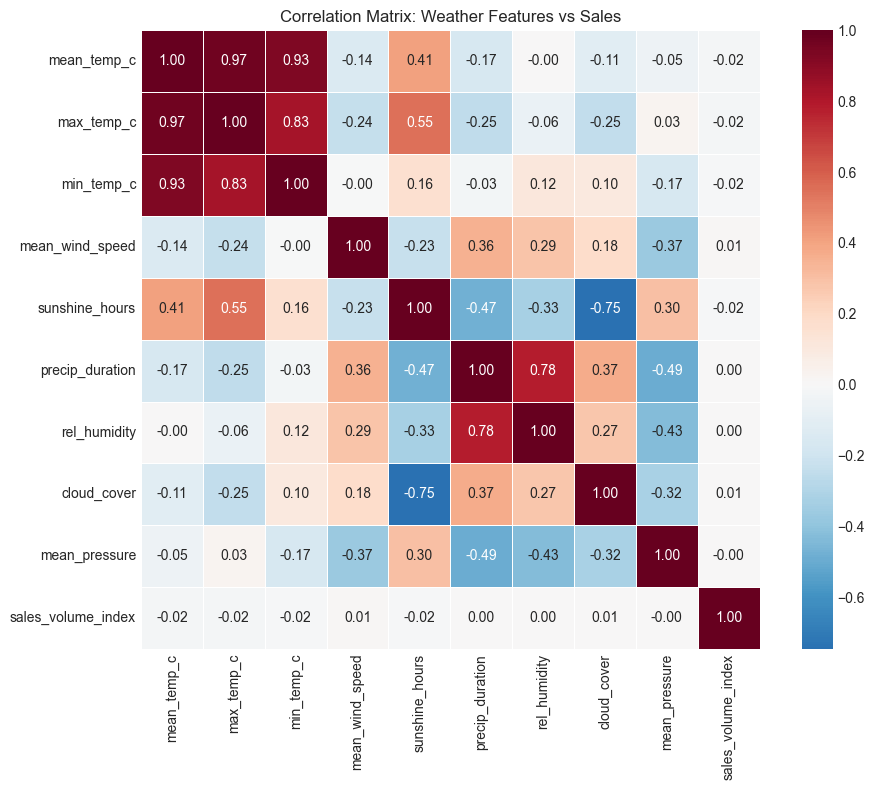


Weather feature correlations with sales (sorted by absolute value):
  max_temp_c          : -0.022
  mean_temp_c         : -0.020
  sunshine_hours      : -0.016
  min_temp_c          : -0.016
  mean_wind_speed     : +0.012
  cloud_cover         : +0.005
  precip_duration     : +0.004
  mean_pressure       : -0.003
  rel_humidity        : +0.000


In [9]:
# Weather correlations heatmap
weather_cols = ['mean_temp_c', 'max_temp_c', 'min_temp_c', 'mean_wind_speed', 'sunshine_hours', 
                'precip_duration', 'rel_humidity', 'cloud_cover', 'mean_pressure']

# Filter to columns that exist
weather_cols = [c for c in weather_cols if c in df.columns]

fig, ax = plt.subplots(figsize=(10, 8))
correlation_df = df[weather_cols + ['sales_volume_index']].corr()
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f', 
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix: Weather Features vs Sales')

plt.tight_layout()
plt.show()

# Print top weather correlations with sales
sales_corr = correlation_df['sales_volume_index'].drop('sales_volume_index').sort_values(key=abs, ascending=False)
print("\nWeather feature correlations with sales (sorted by absolute value):")
for feat, corr in sales_corr.items():
    print(f"  {feat:20s}: {corr:+.3f}")

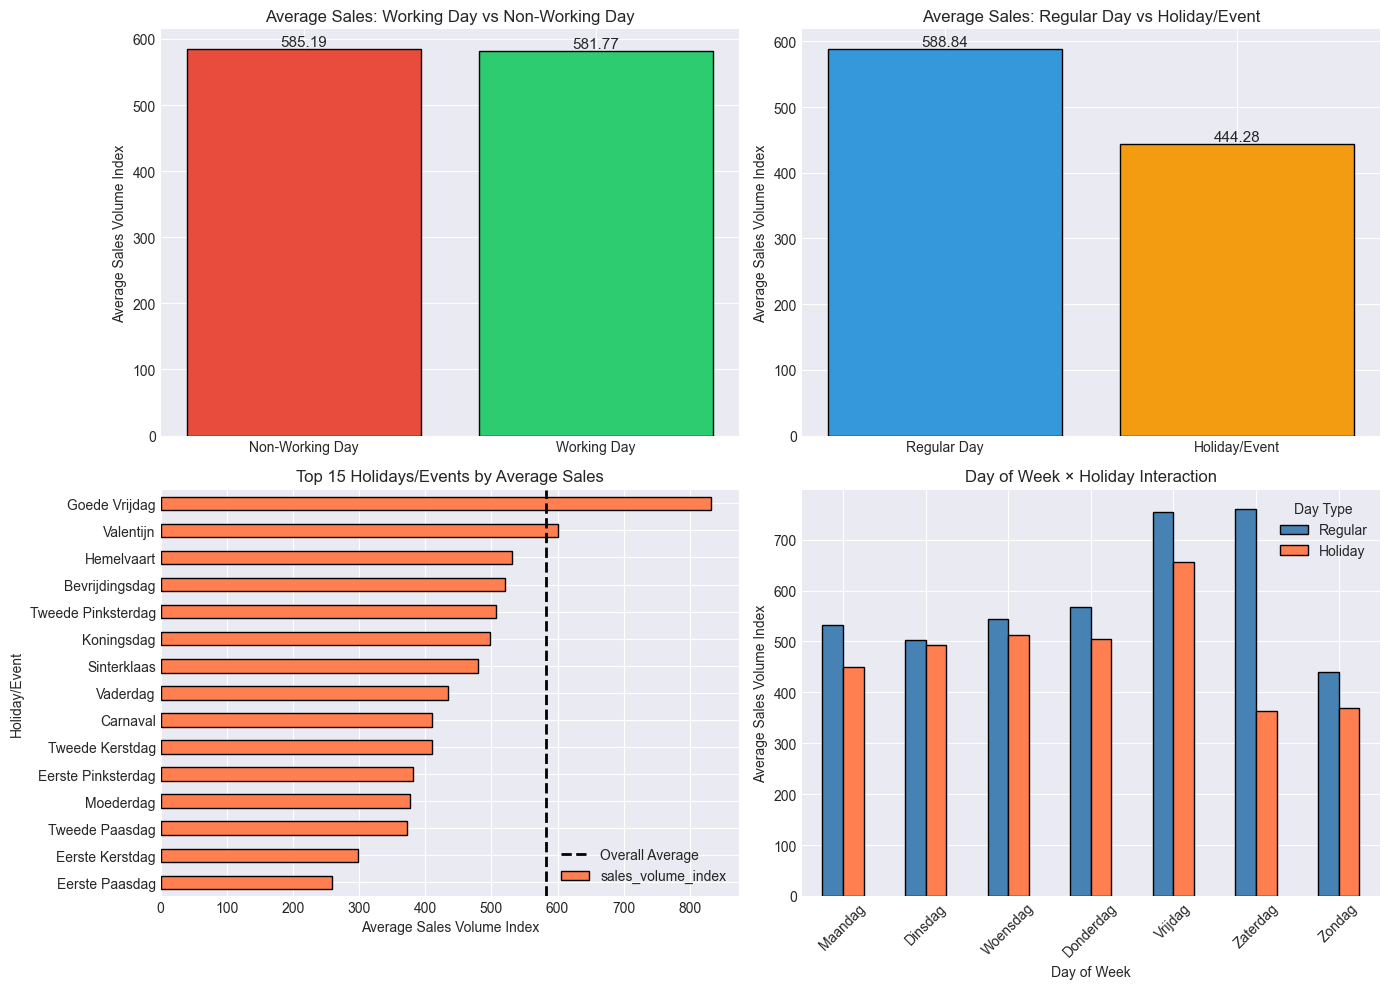

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Working Day vs Non-Working Day
ax1 = axes[0, 0]
working_sales = df.groupby('workingDayIndicator')['sales_volume_index'].agg(['mean', 'count'])
working_sales.index = ['Non-Working Day', 'Working Day']
colors = ['#e74c3c', '#2ecc71']
bars = ax1.bar(working_sales.index, working_sales['mean'], color=colors, edgecolor='black')
ax1.set_ylabel('Average Sales Volume Index')
ax1.set_title('Average Sales: Working Day vs Non-Working Day')
for bar, val in zip(bars, working_sales['mean']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.2f}', ha='center', va='bottom', fontsize=11)

# 2. Holiday vs Regular Day
ax2 = axes[0, 1]
holiday_sales = df.groupby('holidayEventIndicator')['sales_volume_index'].agg(['mean', 'count'])
holiday_sales.index = ['Regular Day', 'Holiday/Event']
colors = ['#3498db', '#f39c12']
bars = ax2.bar(holiday_sales.index, holiday_sales['mean'], color=colors, edgecolor='black')
ax2.set_ylabel('Average Sales Volume Index')
ax2.set_title('Average Sales: Regular Day vs Holiday/Event')
for bar, val in zip(bars, holiday_sales['mean']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.2f}', ha='center', va='bottom', fontsize=11)

# 3. Sales by specific holidays
ax3 = axes[1, 0]
holiday_df = df[df['holidayEventName'].notna()]
if len(holiday_df) > 0:
    holiday_avg = holiday_df.groupby('holidayEventName')['sales_volume_index'].mean().sort_values(ascending=True)
    holiday_avg.tail(15).plot(kind='barh', ax=ax3, color='coral', edgecolor='black')
    ax3.axvline(df['sales_volume_index'].mean(), color='black', linestyle='--', linewidth=2, label='Overall Average')
    ax3.set_xlabel('Average Sales Volume Index')
    ax3.set_ylabel('Holiday/Event')
    ax3.set_title('Top 15 Holidays/Events by Average Sales')
    ax3.legend()

# 4. Day of week + Holiday interaction
ax4 = axes[1, 1]
dow_holiday = df.groupby(['doWName', 'holidayEventIndicator'])['sales_volume_index'].mean().unstack()
dow_holiday.columns = ['Regular', 'Holiday']
dow_holiday = dow_holiday.reindex(['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
dow_holiday.plot(kind='bar', ax=ax4, color=['steelblue', 'coral'], edgecolor='black')
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Average Sales Volume Index')
ax4.set_title('Day of Week × Holiday Interaction')
ax4.tick_params(axis='x', rotation=45)
ax4.legend(title='Day Type')

plt.tight_layout()
plt.show()

SALES ANALYSIS: DAYS BEFORE HOLIDAYS vs REGULAR DAYS

Regular Day Average Sales: 588.84
Holiday Day Average Sales: 444.28

Days Before Holidays:
  1 Day Before Holiday Average: 709.46
  3-Day Average Before Holiday: 735.11
  7-Day Average Before Holiday: 640.58

Comparison to Regular Days (Difference):
  Holiday Day: -144.56 (-24.55%)
  1 Day Before: +120.63 (+20.49%)
  3-Day Average: +146.27 (+24.84%)
  7-Day Average: +51.74 (+8.79%)

Number of observations:
  Holiday Days: 60
  1 Day Before: 48
  3-Day Average: 59
  7-Day Average: 59


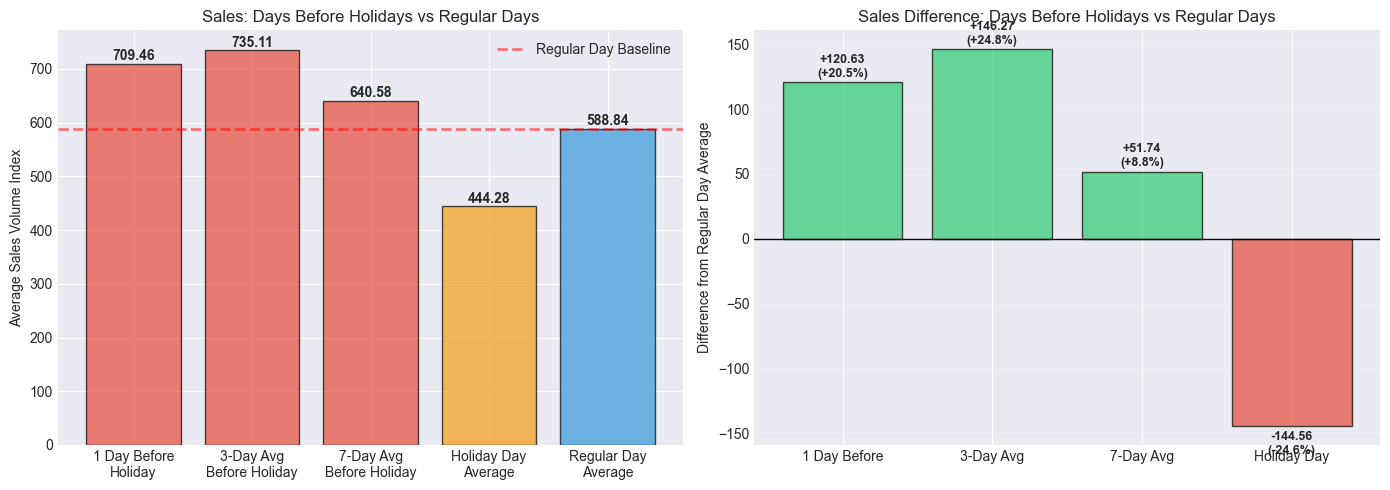

In [11]:
# Analyze sales BEFORE holidays vs regular days
print("=" * 80)
print("SALES ANALYSIS: DAYS BEFORE HOLIDAYS vs REGULAR DAYS")
print("=" * 80)

# Get all unique holiday dates (where holidayEventIndicator == 1)
holiday_dates = df[df['holidayEventIndicator'] == 1]['date'].unique()
holiday_dates = pd.Series(holiday_dates).sort_values()

# Calculate average sales for regular days (non-holidays)
regular_days_avg = df[df['holidayEventIndicator'] == 0]['sales_volume_index'].mean()

# Calculate average sales for holiday days themselves
holiday_days_avg = df[df['holidayEventIndicator'] == 1]['sales_volume_index'].mean()

# Store results
results = {
    'day_before': [],
    '3day_avg_before': [],
    '7day_avg_before': []
}

# For each holiday, find the days before it
for holiday_date in holiday_dates:
    # 1 day before
    day_before = holiday_date - pd.Timedelta(days=1)
    if day_before in df['date'].values:
        day_before_sales = df[df['date'] == day_before]['sales_volume_index'].mean()
        # Only include if it's not itself a holiday
        if df[df['date'] == day_before]['holidayEventIndicator'].iloc[0] == 0:
            results['day_before'].append(day_before_sales)
    
    # 3 days before (average of days -3, -2, -1)
    days_3_before = [holiday_date - pd.Timedelta(days=i) for i in range(1, 4)]
    sales_3days = []
    for day in days_3_before:
        if day in df['date'].values:
            # Only include if it's not a holiday
            if df[df['date'] == day]['holidayEventIndicator'].iloc[0] == 0:
                sales_3days.append(df[df['date'] == day]['sales_volume_index'].mean())
    if len(sales_3days) > 0:
        results['3day_avg_before'].append(np.mean(sales_3days))
    
    # 7 days before (average of days -7, -6, ..., -1)
    days_7_before = [holiday_date - pd.Timedelta(days=i) for i in range(1, 8)]
    sales_7days = []
    for day in days_7_before:
        if day in df['date'].values:
            # Only include if it's not a holiday
            if df[df['date'] == day]['holidayEventIndicator'].iloc[0] == 0:
                sales_7days.append(df[df['date'] == day]['sales_volume_index'].mean())
    if len(sales_7days) > 0:
        results['7day_avg_before'].append(np.mean(sales_7days))

# Calculate averages
avg_day_before = np.mean(results['day_before']) if len(results['day_before']) > 0 else None
avg_3day_before = np.mean(results['3day_avg_before']) if len(results['3day_avg_before']) > 0 else None
avg_7day_before = np.mean(results['7day_avg_before']) if len(results['7day_avg_before']) > 0 else None

# Print results
print(f"\nRegular Day Average Sales: {regular_days_avg:.2f}")
print(f"Holiday Day Average Sales: {holiday_days_avg:.2f}")
print(f"\nDays Before Holidays:")
print(f"  1 Day Before Holiday Average: {avg_day_before:.2f}" if avg_day_before else "  1 Day Before Holiday Average: N/A")
print(f"  3-Day Average Before Holiday: {avg_3day_before:.2f}" if avg_3day_before else "  3-Day Average Before Holiday: N/A")
print(f"  7-Day Average Before Holiday: {avg_7day_before:.2f}" if avg_7day_before else "  7-Day Average Before Holiday: N/A")

print(f"\nComparison to Regular Days (Difference):")
holiday_diff = holiday_days_avg - regular_days_avg
holiday_pct = (holiday_diff / regular_days_avg) * 100
print(f"  Holiday Day: {holiday_diff:+.2f} ({holiday_pct:+.2f}%)")
if avg_day_before:
    diff_1day = avg_day_before - regular_days_avg
    pct_1day = (diff_1day / regular_days_avg) * 100
    print(f"  1 Day Before: {diff_1day:+.2f} ({pct_1day:+.2f}%)")
if avg_3day_before:
    diff_3day = avg_3day_before - regular_days_avg
    pct_3day = (diff_3day / regular_days_avg) * 100
    print(f"  3-Day Average: {diff_3day:+.2f} ({pct_3day:+.2f}%)")
if avg_7day_before:
    diff_7day = avg_7day_before - regular_days_avg
    pct_7day = (diff_7day / regular_days_avg) * 100
    print(f"  7-Day Average: {diff_7day:+.2f} ({pct_7day:+.2f}%)")

print(f"\nNumber of observations:")
print(f"  Holiday Days: {len(holiday_dates)}")
print(f"  1 Day Before: {len(results['day_before'])}")
print(f"  3-Day Average: {len(results['3day_avg_before'])}")
print(f"  7-Day Average: {len(results['7day_avg_before'])}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
ax1 = axes[0]
categories = []
values = []
if avg_day_before:
    categories.append('1 Day Before\nHoliday')
    values.append(avg_day_before)
if avg_3day_before:
    categories.append('3-Day Avg\nBefore Holiday')
    values.append(avg_3day_before)
if avg_7day_before:
    categories.append('7-Day Avg\nBefore Holiday')
    values.append(avg_7day_before)
categories.append('Holiday Day\nAverage')
values.append(holiday_days_avg)
categories.append('Regular Day\nAverage')
values.append(regular_days_avg)

colors = ['#e74c3c' if 'Before' in cat else '#f39c12' if 'Holiday Day' in cat else '#3498db' for cat in categories]
bars = ax1.bar(categories, values, color=colors, edgecolor='black', alpha=0.7)
ax1.axhline(regular_days_avg, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Regular Day Baseline')
ax1.set_ylabel('Average Sales Volume Index')
ax1.set_title('Sales: Days Before Holidays vs Regular Days')
ax1.legend()

# Add value labels on bars
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Difference chart
ax2 = axes[1]
diff_categories = []
diff_values = []
if avg_day_before:
    diff_categories.append('1 Day Before')
    diff_values.append(diff_1day)
if avg_3day_before:
    diff_categories.append('3-Day Avg')
    diff_values.append(diff_3day)
if avg_7day_before:
    diff_categories.append('7-Day Avg')
    diff_values.append(diff_7day)
diff_categories.append('Holiday Day')
diff_values.append(holiday_diff)

colors_diff = ['#2ecc71' if v > 0 else '#e74c3c' for v in diff_values]
bars2 = ax2.bar(diff_categories, diff_values, color=colors_diff, edgecolor='black', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_ylabel('Difference from Regular Day Average')
ax2.set_title('Sales Difference: Days Before Holidays vs Regular Days')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars2, diff_values):
    pct = (val / regular_days_avg) * 100
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (2 if val > 0 else -4), 
             f'{val:+.2f}\n({pct:+.1f}%)', ha='center', va='bottom' if val > 0 else 'top', 
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

SALES ANALYSIS BY CATEGORY: DAYS BEFORE HOLIDAYS vs REGULAR DAYS

CATEGORY: Vlees, Kip en Vis

Regular Day Average Sales: 461.59
Holiday Day Average Sales: 364.60
1 Day Before Holiday Average: 583.79
3-Day Average Before Holiday: 657.68
7-Day Average Before Holiday: 566.02

Comparison to Regular Days:
  Holiday Day: -96.99 (-21.01%)
  1 Day Before: +122.19 (+26.47%)
  3-Day Average: +196.09 (+42.48%)
  7-Day Average: +104.43 (+22.62%)

CATEGORY: Was Reiniging Papier

Regular Day Average Sales: 838.16
Holiday Day Average Sales: 538.16
1 Day Before Holiday Average: 787.66
3-Day Average Before Holiday: 776.87
7-Day Average Before Holiday: 752.16

Comparison to Regular Days:
  Holiday Day: -299.99 (-35.79%)
  1 Day Before: -50.50 (-6.02%)
  3-Day Average: -61.29 (-7.31%)
  7-Day Average: -86.00 (-10.26%)

CATEGORY: Wijn en PSV

Regular Day Average Sales: 608.07
Holiday Day Average Sales: 507.22
1 Day Before Holiday Average: 865.20
3-Day Average Before Holiday: 877.54
7-Day Average Before H

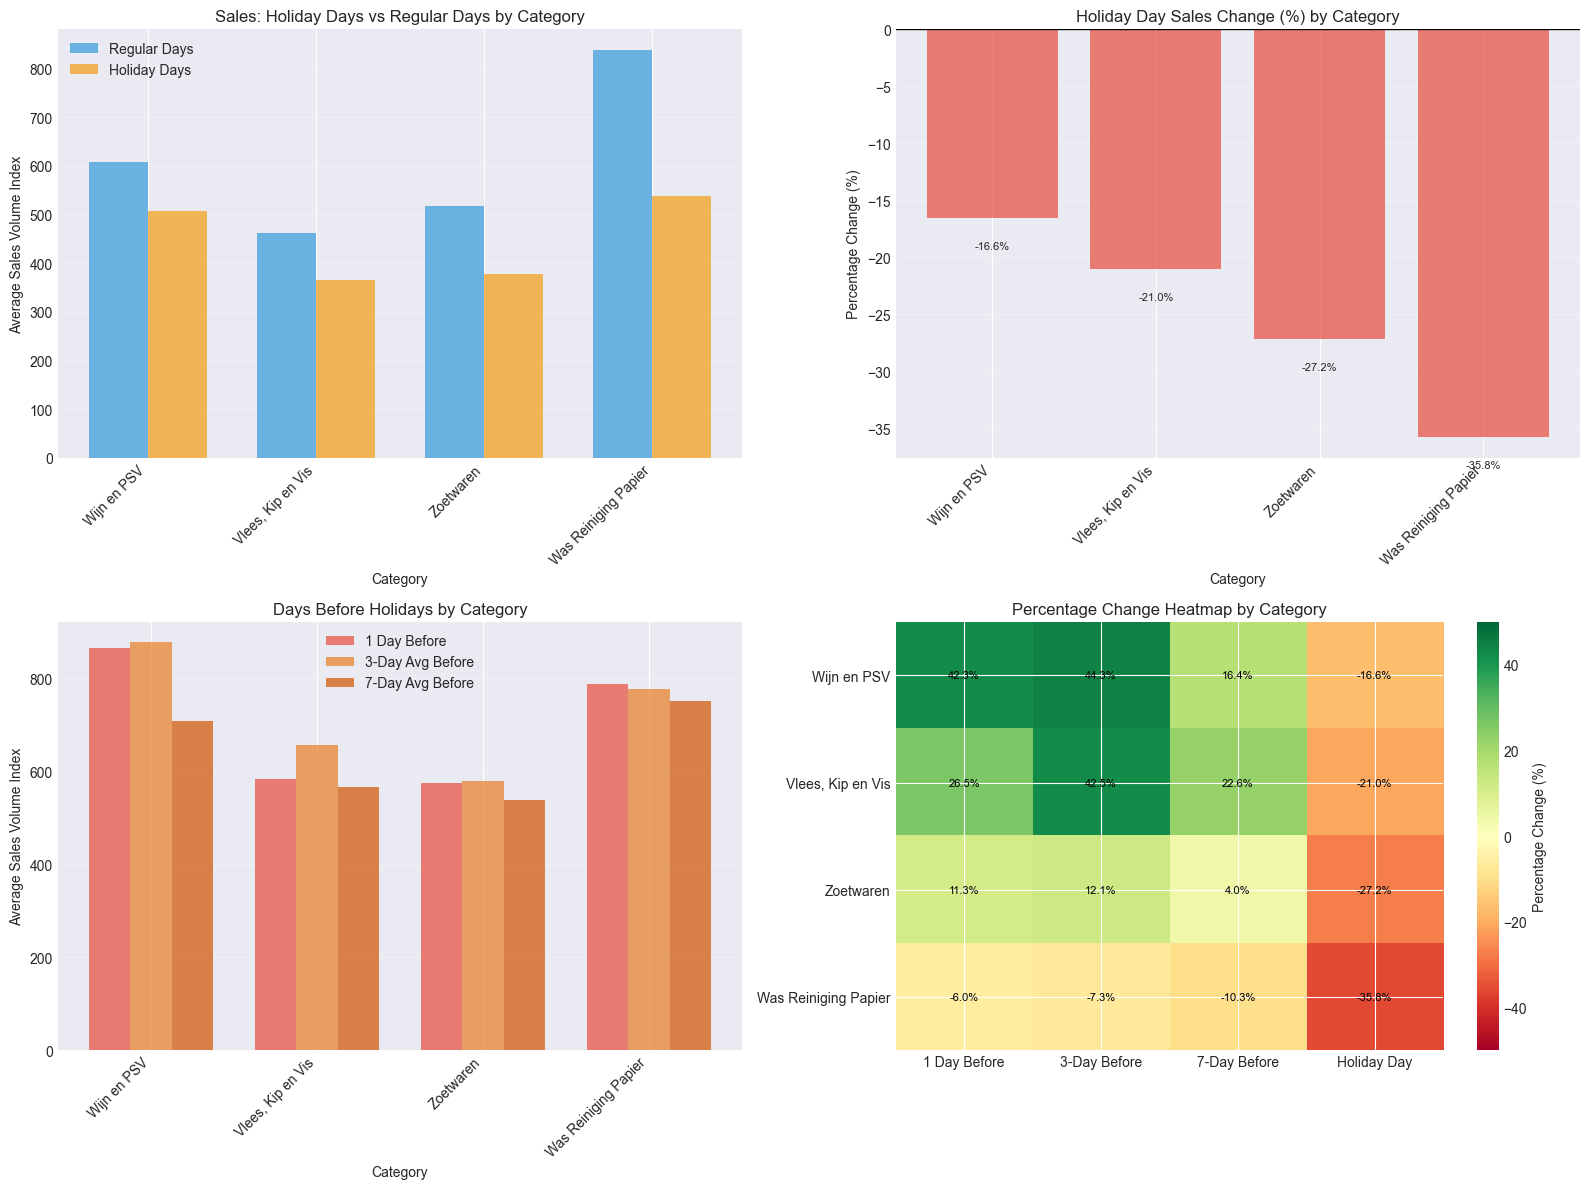

In [12]:
# Analyze sales BEFORE holidays vs regular days BY PRODUCT CATEGORY
print("=" * 80)
print("SALES ANALYSIS BY CATEGORY: DAYS BEFORE HOLIDAYS vs REGULAR DAYS")
print("=" * 80)

# Get unique categories
categories = df['category'].unique()
categories = sorted([cat for cat in categories if pd.notna(cat)])

# Get all unique holiday dates
holiday_dates = df[df['holidayEventIndicator'] == 1]['date'].unique()
holiday_dates = pd.Series(holiday_dates).sort_values()

# Store results by category
category_results = {}

for category in categories:
    print(f"\n{'=' * 80}")
    print(f"CATEGORY: {category}")
    print(f"{'=' * 80}")
    
    # Filter data for this category
    df_cat = df[df['category'] == category].copy()
    
    # Calculate average sales for regular days and holiday days for this category
    regular_days_avg = df_cat[df_cat['holidayEventIndicator'] == 0]['sales_volume_index'].mean()
    holiday_days_avg = df_cat[df_cat['holidayEventIndicator'] == 1]['sales_volume_index'].mean()
    
    # Store results
    results = {
        'day_before': [],
        '3day_avg_before': [],
        '7day_avg_before': []
    }
    
    # For each holiday, find the days before it
    for holiday_date in holiday_dates:
        # 1 day before
        day_before = holiday_date - pd.Timedelta(days=1)
        if day_before in df_cat['date'].values:
            day_before_sales = df_cat[df_cat['date'] == day_before]['sales_volume_index'].mean()
            # Only include if it's not itself a holiday
            if df_cat[df_cat['date'] == day_before]['holidayEventIndicator'].iloc[0] == 0:
                results['day_before'].append(day_before_sales)
        
        # 3 days before (average of days -3, -2, -1)
        days_3_before = [holiday_date - pd.Timedelta(days=i) for i in range(1, 4)]
        sales_3days = []
        for day in days_3_before:
            if day in df_cat['date'].values:
                # Only include if it's not a holiday
                if df_cat[df_cat['date'] == day]['holidayEventIndicator'].iloc[0] == 0:
                    sales_3days.append(df_cat[df_cat['date'] == day]['sales_volume_index'].mean())
        if len(sales_3days) > 0:
            results['3day_avg_before'].append(np.mean(sales_3days))
        
        # 7 days before (average of days -7, -6, ..., -1)
        days_7_before = [holiday_date - pd.Timedelta(days=i) for i in range(1, 8)]
        sales_7days = []
        for day in days_7_before:
            if day in df_cat['date'].values:
                # Only include if it's not a holiday
                if df_cat[df_cat['date'] == day]['holidayEventIndicator'].iloc[0] == 0:
                    sales_7days.append(df_cat[df_cat['date'] == day]['sales_volume_index'].mean())
        if len(sales_7days) > 0:
            results['7day_avg_before'].append(np.mean(sales_7days))
    
    # Calculate averages
    avg_day_before = np.mean(results['day_before']) if len(results['day_before']) > 0 else None
    avg_3day_before = np.mean(results['3day_avg_before']) if len(results['3day_avg_before']) > 0 else None
    avg_7day_before = np.mean(results['7day_avg_before']) if len(results['7day_avg_before']) > 0 else None
    
    # Store in category_results
    category_results[category] = {
        'regular_days_avg': regular_days_avg,
        'holiday_days_avg': holiday_days_avg,
        'avg_day_before': avg_day_before,
        'avg_3day_before': avg_3day_before,
        'avg_7day_before': avg_7day_before,
        'n_observations': {
            '1day_before': len(results['day_before']),
            '3day_before': len(results['3day_avg_before']),
            '7day_before': len(results['7day_avg_before'])
        }
    }
    
    # Print results for this category
    print(f"\nRegular Day Average Sales: {regular_days_avg:.2f}")
    print(f"Holiday Day Average Sales: {holiday_days_avg:.2f}")
    if avg_day_before:
        print(f"1 Day Before Holiday Average: {avg_day_before:.2f}")
    if avg_3day_before:
        print(f"3-Day Average Before Holiday: {avg_3day_before:.2f}")
    if avg_7day_before:
        print(f"7-Day Average Before Holiday: {avg_7day_before:.2f}")
    
    # Comparison
    holiday_diff = holiday_days_avg - regular_days_avg
    holiday_pct = (holiday_diff / regular_days_avg) * 100
    print(f"\nComparison to Regular Days:")
    print(f"  Holiday Day: {holiday_diff:+.2f} ({holiday_pct:+.2f}%)")
    if avg_day_before:
        diff_1day = avg_day_before - regular_days_avg
        pct_1day = (diff_1day / regular_days_avg) * 100
        print(f"  1 Day Before: {diff_1day:+.2f} ({pct_1day:+.2f}%)")
    if avg_3day_before:
        diff_3day = avg_3day_before - regular_days_avg
        pct_3day = (diff_3day / regular_days_avg) * 100
        print(f"  3-Day Average: {diff_3day:+.2f} ({pct_3day:+.2f}%)")
    if avg_7day_before:
        diff_7day = avg_7day_before - regular_days_avg
        pct_7day = (diff_7day / regular_days_avg) * 100
        print(f"  7-Day Average: {diff_7day:+.2f} ({pct_7day:+.2f}%)")

# Create summary DataFrame
summary_data = []
for category, results in category_results.items():
    summary_data.append({
        'Category': category,
        'Regular Days Avg': results['regular_days_avg'],
        'Holiday Day Avg': results['holiday_days_avg'],
        '1 Day Before Avg': results['avg_day_before'] if results['avg_day_before'] else None,
        '3-Day Before Avg': results['avg_3day_before'] if results['avg_3day_before'] else None,
        '7-Day Before Avg': results['avg_7day_before'] if results['avg_7day_before'] else None,
        'Holiday Diff': results['holiday_days_avg'] - results['regular_days_avg'],
        'Holiday Pct': ((results['holiday_days_avg'] - results['regular_days_avg']) / results['regular_days_avg']) * 100
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Holiday Pct', ascending=False)

print(f"\n{'=' * 80}")
print("SUMMARY TABLE: ALL CATEGORIES")
print(f"{'=' * 80}")
print(summary_df.to_string(index=False))

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Holiday Day vs Regular Day by Category
ax1 = axes[0, 0]
cat_order = summary_df['Category'].values
x_pos = np.arange(len(cat_order))
width = 0.35

regular_values = summary_df['Regular Days Avg'].values
holiday_values = summary_df['Holiday Day Avg'].values

bars1 = ax1.bar(x_pos - width/2, regular_values, width, label='Regular Days', color='#3498db', alpha=0.7)
bars2 = ax1.bar(x_pos + width/2, holiday_values, width, label='Holiday Days', color='#f39c12', alpha=0.7)

ax1.set_xlabel('Category')
ax1.set_ylabel('Average Sales Volume Index')
ax1.set_title('Sales: Holiday Days vs Regular Days by Category')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(cat_order, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Holiday Percentage Change by Category
ax2 = axes[0, 1]
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in summary_df['Holiday Pct'].values]
bars = ax2.bar(x_pos, summary_df['Holiday Pct'].values, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Category')
ax2.set_ylabel('Percentage Change (%)')
ax2.set_title('Holiday Day Sales Change (%) by Category')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cat_order, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, summary_df['Holiday Pct'].values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if val > 0 else -2),
             f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

# 3. Days Before Holidays Comparison
ax3 = axes[1, 0]
categories_with_data = []
day_before_vals = []
day_3before_vals = []
day_7before_vals = []

for category in cat_order:
    if category_results[category]['avg_day_before'] is not None:
        categories_with_data.append(category)
        day_before_vals.append(category_results[category]['avg_day_before'])
        day_3before_vals.append(category_results[category]['avg_3day_before'] if category_results[category]['avg_3day_before'] else np.nan)
        day_7before_vals.append(category_results[category]['avg_7day_before'] if category_results[category]['avg_7day_before'] else np.nan)

if len(categories_with_data) > 0:
    x_pos2 = np.arange(len(categories_with_data))
    width2 = 0.25
    
    bars1 = ax3.bar(x_pos2 - width2, day_before_vals, width2, label='1 Day Before', color='#e74c3c', alpha=0.7)
    bars2 = ax3.bar(x_pos2, day_3before_vals, width2, label='3-Day Avg Before', color='#e67e22', alpha=0.7)
    bars3 = ax3.bar(x_pos2 + width2, day_7before_vals, width2, label='7-Day Avg Before', color='#d35400', alpha=0.7)
    
    ax3.set_xlabel('Category')
    ax3.set_ylabel('Average Sales Volume Index')
    ax3.set_title('Days Before Holidays by Category')
    ax3.set_xticks(x_pos2)
    ax3.set_xticklabels(categories_with_data, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# 4. Heatmap of percentage changes
ax4 = axes[1, 1]
heatmap_data = []
for category in cat_order:
    row = []
    results = category_results[category]
    if results['avg_day_before']:
        row.append(((results['avg_day_before'] - results['regular_days_avg']) / results['regular_days_avg']) * 100)
    else:
        row.append(np.nan)
    if results['avg_3day_before']:
        row.append(((results['avg_3day_before'] - results['regular_days_avg']) / results['regular_days_avg']) * 100)
    else:
        row.append(np.nan)
    if results['avg_7day_before']:
        row.append(((results['avg_7day_before'] - results['regular_days_avg']) / results['regular_days_avg']) * 100)
    else:
        row.append(np.nan)
    row.append(((results['holiday_days_avg'] - results['regular_days_avg']) / results['regular_days_avg']) * 100)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=cat_order, columns=['1 Day Before', '3-Day Before', '7-Day Before', 'Holiday Day'])

im = ax4.imshow(heatmap_df.values, aspect='auto', cmap='RdYlGn', vmin=-50, vmax=50)
ax4.set_xticks(np.arange(len(heatmap_df.columns)))
ax4.set_yticks(np.arange(len(heatmap_df.index)))
ax4.set_xticklabels(heatmap_df.columns)
ax4.set_yticklabels(heatmap_df.index)
ax4.set_title('Percentage Change Heatmap by Category')

# Add text annotations
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            text = ax4.text(j, i, f'{val:.1f}%', ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=ax4, label='Percentage Change (%)')

plt.tight_layout()
plt.show()


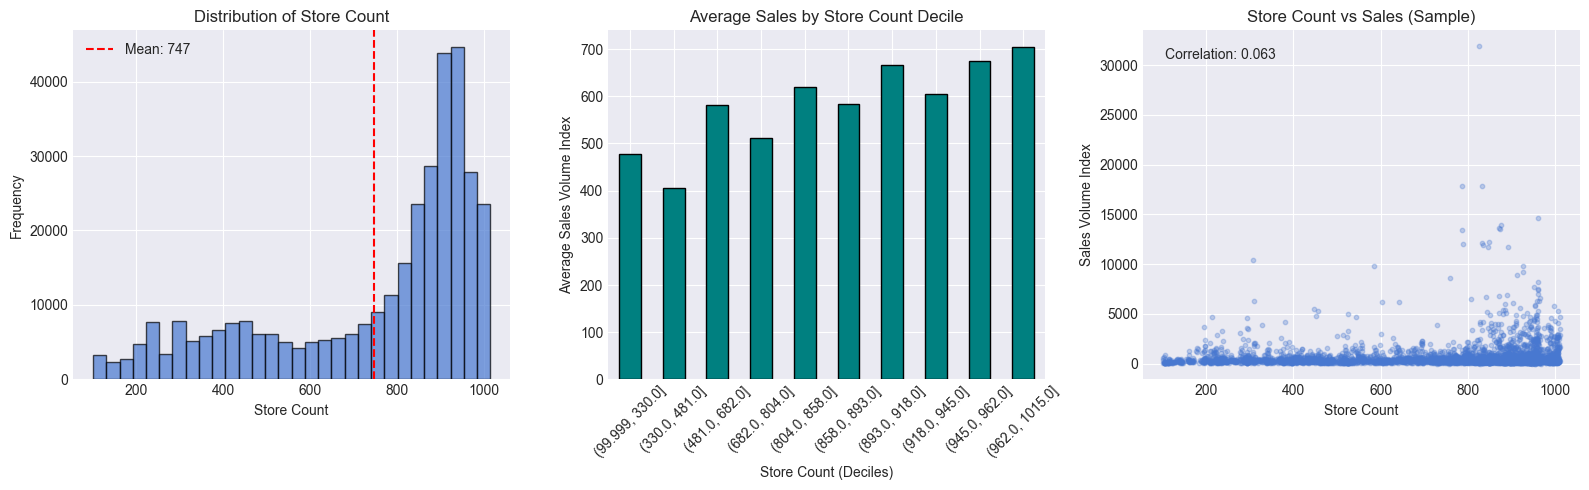

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Store count distribution
ax1 = axes[0]
df['storeCount'].hist(bins=30, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Store Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Store Count')
ax1.axvline(df['storeCount'].mean(), color='red', linestyle='--', label=f"Mean: {df['storeCount'].mean():.0f}")
ax1.legend()

# 2. Store count vs Sales (aggregated)
ax2 = axes[1]
store_bins = pd.qcut(df['storeCount'], q=10, duplicates='drop')
store_sales = df.groupby(store_bins, observed=True)['sales_volume_index'].mean()
store_sales.plot(kind='bar', ax=ax2, color='teal', edgecolor='black')
ax2.set_xlabel('Store Count (Deciles)')
ax2.set_ylabel('Average Sales Volume Index')
ax2.set_title('Average Sales by Store Count Decile')
ax2.tick_params(axis='x', rotation=45)

# 3. Store count correlation
ax3 = axes[2]
# Sample for visualization
sample = df.sample(min(5000, len(df)), random_state=42)
ax3.scatter(sample['storeCount'], sample['sales_volume_index'], alpha=0.3, s=10)
ax3.set_xlabel('Store Count')
ax3.set_ylabel('Sales Volume Index')
ax3.set_title('Store Count vs Sales (Sample)')
corr = df['storeCount'].corr(df['sales_volume_index'])
ax3.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax3.transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

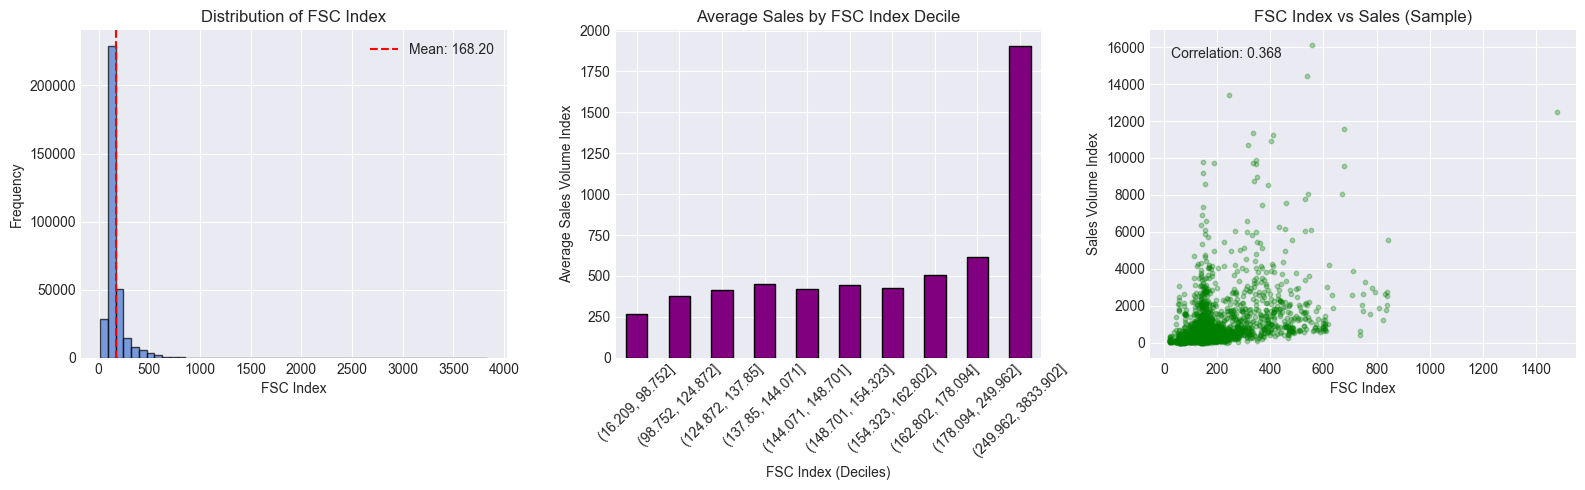


FSC Index Statistics:
  Non-null values: 343,831 (99.99%)
  Null values: 18 (0.01%)
  Mean: 168.20
  Median: 148.70


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. FSC Index distribution
ax1 = axes[0]
df['FSC_index'].dropna().hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_xlabel('FSC Index')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of FSC Index')
ax1.axvline(df['FSC_index'].mean(), color='red', linestyle='--', label=f"Mean: {df['FSC_index'].mean():.2f}")
ax1.legend()

# 2. FSC Index vs Sales
ax2 = axes[1]
fsc_bins = pd.qcut(df['FSC_index'].dropna(), q=10, duplicates='drop')
df_temp = df.copy()
df_temp['fsc_bin'] = fsc_bins
fsc_sales = df_temp.groupby('fsc_bin', observed=True)['sales_volume_index'].mean()
fsc_sales.plot(kind='bar', ax=ax2, color='purple', edgecolor='black')
ax2.set_xlabel('FSC Index (Deciles)')
ax2.set_ylabel('Average Sales Volume Index')
ax2.set_title('Average Sales by FSC Index Decile')
ax2.tick_params(axis='x', rotation=45)

# 3. FSC vs Sales scatter
ax3 = axes[2]
sample = df.dropna(subset=['FSC_index']).sample(min(5000, len(df)), random_state=42)
ax3.scatter(sample['FSC_index'], sample['sales_volume_index'], alpha=0.3, s=10, color='green')
ax3.set_xlabel('FSC Index')
ax3.set_ylabel('Sales Volume Index')
ax3.set_title('FSC Index vs Sales (Sample)')
corr = df['FSC_index'].corr(df['sales_volume_index'])
ax3.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax3.transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

print(f"\nFSC Index Statistics:")
print(f"  Non-null values: {df['FSC_index'].notna().sum():,} ({df['FSC_index'].notna().mean()*100:.2f}%)")
print(f"  Null values: {df['FSC_index'].isna().sum():,} ({df['FSC_index'].isna().mean()*100:.2f}%)")
print(f"  Mean: {df['FSC_index'].mean():.2f}")
print(f"  Median: {df['FSC_index'].median():.2f}")

In [ ]:
# Extract holidays and their dates by year
print("=" * 80)
print("HOLIDAYS BY YEAR")
print("=" * 80)

# Filter for rows where holidayEventName is not null
holidays_df = df[df['holidayEventName'].notna()].copy()

# Extract year from date column
holidays_df['year'] = holidays_df['date'].dt.year

# Group by year and holiday name, collect all dates for each holiday
holidays_by_year = holidays_df.groupby(['year', 'holidayEventName'])['date'].apply(
    lambda x: sorted(x.unique())
).reset_index(name='dates')

# Display holidays grouped by year
for year in sorted(holidays_by_year['year'].unique()):
    print(f"\n{'=' * 80}")
    print(f"YEAR: {year}")
    print(f"{'=' * 80}")
    
    year_holidays = holidays_by_year[holidays_by_year['year'] == year]
    
    for idx, row in year_holidays.iterrows():
        holiday_name = row['holidayEventName']
        dates = row['dates']
        
        # Format dates as strings
        date_strs = [d.strftime('%Y-%m-%d (%A)') for d in dates]
        
        print(f"\n  Holiday: {holiday_name}")
        if len(dates) == 1:
            print(f"    Date: {date_strs[0]}")
        else:
            print(f"    Dates:")
            for date_str in date_strs:
                print(f"      - {date_str}")

# Summary statistics
print(f"\n{'=' * 80}")
print("SUMMARY")
print(f"{'=' * 80}")
print(f"Total unique holidays: {holidays_df['holidayEventName'].nunique()}")
print(f"Total holiday dates: {len(holidays_df)}")
print(f"Years covered: {sorted(holidays_df['year'].unique())}")
print(f"\nHolidays per year:")
for year in sorted(holidays_df['year'].unique()):
    year_count = holidays_df[holidays_df['year'] == year]['holidayEventName'].nunique()
    year_dates = holidays_df[holidays_df['year'] == year].shape[0]
    print(f"  {year}: {year_count} unique holidays, {year_dates} holiday dates")


HOLIDAYS BY YEAR

YEAR: 2021

  Holiday: Bevrijdingsdag
    Date: 2021-05-05 (Wednesday)

  Holiday: Eerste Kerstdag
    Date: 2021-12-25 (Saturday)

  Holiday: Eerste Paasdag
    Date: 2021-04-04 (Sunday)

  Holiday: Eerste Pinksterdag
    Date: 2021-05-23 (Sunday)

  Holiday: Goede Vrijdag
    Date: 2021-04-02 (Friday)

  Holiday: Hemelvaart
    Date: 2021-05-13 (Thursday)

  Holiday: Koningsdag
    Date: 2021-04-27 (Tuesday)

  Holiday: Moederdag
    Date: 2021-05-09 (Sunday)

  Holiday: Nieuwjaar
    Date: 2021-01-01 (Friday)

  Holiday: Sinterklaas
    Date: 2021-12-05 (Sunday)

  Holiday: Tweede Kerstdag
    Date: 2021-12-26 (Sunday)

  Holiday: Tweede Paasdag
    Date: 2021-04-05 (Monday)

  Holiday: Tweede Pinksterdag
    Date: 2021-05-24 (Monday)

  Holiday: Vaderdag
    Date: 2021-06-20 (Sunday)

  Holiday: Valentijn
    Date: 2021-02-14 (Sunday)

YEAR: 2022

  Holiday: Bevrijdingsdag
    Date: 2022-05-05 (Thursday)

  Holiday: Carnaval
    Date: 2022-02-27 (Sunday)

  Holida

In [ ]:
# Time Series Plot: Sales by Article ID (4 articles per plot, grouped by category)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

# Get unique categories
categories = sorted(df['category'].unique())

# Process each category
for category in categories:
    print(f"\n{'=' * 80}")
    print(f"Processing category: {category}")
    print(f"{'=' * 80}")
    
    # Filter data for this category
    cat_df = df[df['category'] == category].copy()
    
    # Get unique article IDs for this category
    article_ids = sorted(cat_df['articleId'].unique())
    n_articles = len(article_ids)
    
    print(f"Number of articles in this category: {n_articles}")
    
    if n_articles == 0:
        continue
    
    # Calculate number of plots needed (4 articles per plot)
    n_plots = math.ceil(n_articles / 4)
    
    # Group by date and articleId to calculate mean and CI for each article over time
    # (in case there are multiple observations per date-article, e.g., from different stores)
    time_series_data = cat_df.groupby(['date', 'articleId'])['sales_volume_index'].agg([
        'mean',
        'std',
        'count'
    ]).reset_index()
    
    # Calculate 95% confidence interval
    time_series_data['ci_lower'] = np.nan
    time_series_data['ci_upper'] = np.nan
    
    for idx, row in time_series_data.iterrows():
        if row['count'] > 1 and not np.isnan(row['std']):
            # Calculate standard error
            se = row['std'] / np.sqrt(row['count'])
            # Use t-distribution for 95% CI (df = n-1)
            t_critical = stats.t.ppf(0.975, row['count'] - 1)
            time_series_data.loc[idx, 'ci_lower'] = row['mean'] - t_critical * se
            time_series_data.loc[idx, 'ci_upper'] = row['mean'] + t_critical * se
        else:
            # If only one observation, use the mean as both bounds
            time_series_data.loc[idx, 'ci_lower'] = row['mean']
            time_series_data.loc[idx, 'ci_upper'] = row['mean']
    
    # Create plots (4 articles per plot)
    for plot_idx in range(n_plots):
        # Get articles for this plot (4 articles)
        start_idx = plot_idx * 4
        end_idx = min(start_idx + 4, n_articles)
        plot_articles = article_ids[start_idx:end_idx]
        
        # Create subplot (2x2 for 4 articles)
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()
        
        # Plot each article
        for subplot_idx, article_id in enumerate(plot_articles):
            ax = axes[subplot_idx]
            
            # Get data for this article
            article_data = time_series_data[time_series_data['articleId'] == article_id].sort_values('date')
            
            if len(article_data) > 0:
                dates = article_data['date']
                mean_vals = article_data['mean']
                ci_lower = article_data['ci_lower']
                ci_upper = article_data['ci_upper']
                
                # Plot mean line
                ax.plot(dates, mean_vals, label='Mean', linewidth=2, color='#2c3e50')
                
                # Fill 95% confidence interval
                ax.fill_between(dates, ci_lower, ci_upper, alpha=0.3, color='#3498db', label='95% CI')
                
                # Shorten article ID for display (show first 20 chars)
                article_display = article_id[:20] + '...' if len(article_id) > 20 else article_id
                ax.set_title(f'Article: {article_display}', fontsize=11, fontweight='bold')
                ax.set_xlabel('Date', fontsize=9)
                ax.set_ylabel('Sales Volume Index', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.legend(loc='best', fontsize=8)
                
                # Rotate x-axis labels
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            else:
                ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Article: {article_id[:20]}...', fontsize=11)
        
        # Hide unused subplots if less than 4 articles in last plot
        for idx in range(len(plot_articles), 4):
            axes[idx].set_visible(False)
        
        # Main title for the plot
        plt.suptitle(f'{category} - Articles {start_idx+1}-{end_idx} of {n_articles} (Plot {plot_idx+1}/{n_plots})', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    
    # Print summary for this category
    print(f"\nCategory Summary: {category}")
    print(f"  Total articles: {n_articles}")
    print(f"  Total plots created: {n_plots}")
    print(f"  Date range: {cat_df['date'].min()} to {cat_df['date'].max()}")

print(f"\n{'=' * 80}")
print("All time series plots completed!")
print(f"{'=' * 80}")


In [ ]:
# Time Series Plot: Sales by Article ID (4 articles per plot, grouped by category)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

# Get unique categories
categories = sorted(df['category'].unique())

# Process each category
for category in categories:
    print(f"\n{'=' * 80}")
    print(f"Processing category: {category}")
    print(f"{'=' * 80}")
    
    # Filter data for this category
    cat_df = df[df['category'] == category].copy()
    
    # Get unique article IDs for this category
    article_ids = sorted(cat_df['articleId'].unique())
    n_articles = len(article_ids)
    
    print(f"Number of articles in this category: {n_articles}")
    
    if n_articles == 0:
        continue
    
    # Calculate number of plots needed (4 articles per plot)
    # Calculate articles per plot: total articles divided by 4
    articles_per_plot = max(1, n_articles // 4)  # At least 1 article per plot
    n_plots = math.ceil(n_articles / articles_per_plot) if articles_per_plot > 0 else 1
    
    # Group by date and articleId to calculate mean and CI for each article over time
    # (in case there are multiple observations per date-article, e.g., from different stores)
    time_series_data = cat_df.groupby(['date', 'articleId'])['sales_volume_index'].agg([
        'mean',
        'std',
        'count'
    ]).reset_index()
    
    # Calculate 95% confidence interval
    time_series_data['ci_lower'] = np.nan
    time_series_data['ci_upper'] = np.nan
    
    for idx, row in time_series_data.iterrows():
        if row['count'] > 1 and not np.isnan(row['std']):
            # Calculate standard error
            se = row['std'] / np.sqrt(row['count'])
            # Use t-distribution for 95% CI (df = n-1)
            t_critical = stats.t.ppf(0.975, row['count'] - 1)
            time_series_data.loc[idx, 'ci_lower'] = row['mean'] - t_critical * se
            time_series_data.loc[idx, 'ci_upper'] = row['mean'] + t_critical * se
        else:
            # If only one observation, use the mean as both bounds
            time_series_data.loc[idx, 'ci_lower'] = row['mean']
            time_series_data.loc[idx, 'ci_upper'] = row['mean']
    
    # Create plots (articles_per_plot articles per plot)
    for plot_idx in range(n_plots):
        # Get articles for this plot (4 articles)
        start_idx = plot_idx * articles_per_plot
        end_idx = min(start_idx + articles_per_plot, n_articles)
        plot_articles = article_ids[start_idx:end_idx]
        
        # Create subplot layout (dynamic based on articles_per_plot)
        # Calculate grid dimensions
        if articles_per_plot == 1:
            rows, cols = 1, 1
        elif articles_per_plot == 2:
            rows, cols = 1, 2
        elif articles_per_plot <= 4:
            rows, cols = 2, 2
        elif articles_per_plot <= 6:
            rows, cols = 2, 3
        elif articles_per_plot <= 9:
            rows, cols = 3, 3
        elif articles_per_plot <= 12:
            rows, cols = 3, 4
        else:
            rows, cols = 4, 4
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        axes = axes.flatten() if articles_per_plot > 1 else [axes]
        axes = axes.flatten()
        
        # Plot each article
        for subplot_idx, article_id in enumerate(plot_articles):
            ax = axes[subplot_idx]
            
            # Get data for this article
            article_data = time_series_data[time_series_data['articleId'] == article_id].sort_values('date')
            
            if len(article_data) > 0:
                dates = article_data['date']
                mean_vals = article_data['mean']
                ci_lower = article_data['ci_lower']
                ci_upper = article_data['ci_upper']
                
                # Plot mean line
                ax.plot(dates, mean_vals, label='Mean', linewidth=2, color='#2c3e50')
                
                # Fill 95% confidence interval
                ax.fill_between(dates, ci_lower, ci_upper, alpha=0.3, color='#3498db', label='95% CI')
                
                # Shorten article ID for display (show first 20 chars)
                article_display = article_id[:20] + '...' if len(article_id) > 20 else article_id
                ax.set_title(f'Article: {article_display}', fontsize=11, fontweight='bold')
                ax.set_xlabel('Date', fontsize=9)
                ax.set_ylabel('Sales Volume Index', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.legend(loc='best', fontsize=8)
                
                # Rotate x-axis labels
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            else:
                ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'Article: {article_id[:20]}...', fontsize=11)
        
        # Hide unused subplots if less than articles_per_plot articles in last plot
        for idx in range(len(plot_articles), rows * cols):
            axes[idx].set_visible(False)
        
        # Main title for the plot
        plt.suptitle(f'{category} - Articles {start_idx+1}-{end_idx} of {n_articles} (Plot {plot_idx+1}/{n_plots})', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    
    # Print summary for this category
    print(f"\nCategory Summary: {category}")
    print(f"  Total articles: {n_articles}")
    print(f"  Total plots created: {n_plots}")
    print(f"  Date range: {cat_df['date'].min()} to {cat_df['date'].max()}")

print(f"\n{'=' * 80}")
print("All time series plots completed!")
print(f"{'=' * 80}")